In [114]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each 

In [115]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# Classification number setting

In [116]:
NUM_CLASSES = 5

# load learing data

In [117]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [118]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model Building

In [120]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [121]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 42)                0         
                                                                 
 dense_15 (Dense)            (None, 20)                860       
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_16 (Dense)            (None, 10)                210       
                                                                 
 dense_17 (Dense)            (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [122]:
# Model Checkpoint
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [123]:
# Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training

In [124]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/33 [..............................] - ETA: 13s - loss: 1.8796 - accuracy: 0.0391
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
33/33 [==============================] - 1s 6ms/step - loss: 1.7205 - accuracy: 0.1217 - val_loss: 1.5705 - val_accuracy: 0.2787
Epoch 2/1000
30/33 [==========================>...] - ETA: 0s - loss: 1.5554 - accuracy: 0.2729
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
33/33 [==============================] - 0s 3ms/step - loss: 1.5513 - accuracy: 0.2780 - val_loss: 1.4553 - val_accuracy: 0.4587
Epoch 3/1000
 1/33 [..............................] - ETA: 0s - loss: 1.4684 - accuracy: 0.2891
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
33/33 [==============================] - 0s 3ms/step - loss: 1.4339 - accuracy: 0.3806 - val_loss: 1.3332 - val_accuracy: 0.5435
Epoch 4/1000
 1/33 [..............................] - ETA: 0s - loss: 1.3573 - accuracy: 0.5078


In [125]:
# model Evalution
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 2ms/step - loss: 0.2346 - accuracy: 0.9700


In [126]:
# Load a saved
model = tf.keras.models.load_model(model_save_path)

In [127]:
# Reasoing Testing
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 46ms/step
[4.3199409e-02 7.2413009e-01 1.3944586e-01 9.2548400e-02 6.7623943e-04]
1


# Confusion Matrix

43/43 [==============================] - 0s 1ms/step


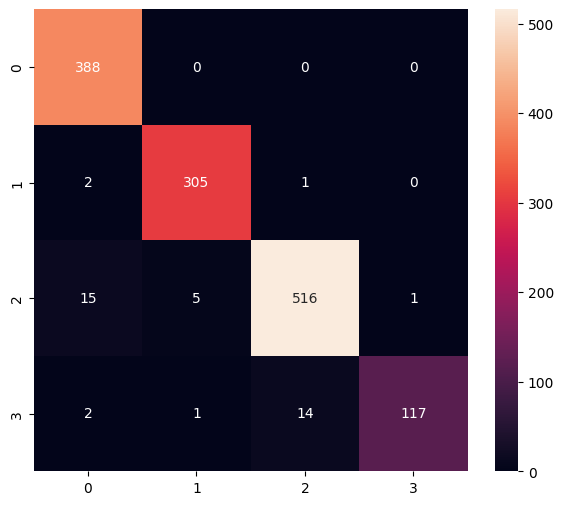

Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       388
           1       0.98      0.99      0.99       308
           2       0.97      0.96      0.97       537
           3       0.99      0.87      0.93       134

    accuracy                           0.97      1367
   macro avg       0.97      0.96      0.96      1367
weighted avg       0.97      0.97      0.97      1367



In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [129]:
# Save as interfacce-oly model
model.save(model_save_path, include_optimizer=False)

In [130]:
# Transform
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpgp0kn08b/assets


INFO:tensorflow:Assets written to: /tmp/tmpgp0kn08b/assets
2022-12-30 02:12:19.552128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-30 02:12:19.552171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-30 02:12:19.552328: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgp0kn08b
2022-12-30 02:12:19.553524: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-30 02:12:19.553545: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgp0kn08b
2022-12-30 02:12:19.557865: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-30 02:12:19.589626: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgp0kn08b
2022-12-30 02:12:19.597804: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

6652

# Reasoning Test

In [131]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [132]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [133]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [134]:
%%time
# implement recommendation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 65 µs, sys: 7 µs, total: 72 µs
Wall time: 83.9 µs


In [135]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.3199372e-02 7.2413015e-01 1.3944590e-01 9.2548370e-02 6.7623885e-04]
1
